# Scenario B - Baseline Variation

In this scenario the baseline underlying a spectrum with a fixed number of Gaussian peaks is varied between no baseline, a constant y-offset and a linear baseline. All datasets contain 3 peaks and the noise level is kept constant at 1%.

The models used in the inference of the parameters are formulated as follows:

1. No baseline:
\begin{equation}
\large y = f(x) = \sum\limits_{m=1}^M \big[A_m \cdot e^{-\frac{(x-\mu_m)^2}{2\cdot\sigma_m^2}}\big] + \epsilon
\end{equation}

2. Constant offset:
\begin{equation}
\large y = f(x) = \sum\limits_{m=1}^M \big[A_m \cdot e^{-\frac{(x-\mu_m)^2}{2\cdot\sigma_m^2}}\big] + a_0 + \epsilon
\end{equation}

3. Linear baseline:
\begin{equation}
\large y = f(x) = \sum\limits_{m=1}^M \big[A_m \cdot e^{-\frac{(x-\mu_m)^2}{2\cdot\sigma_m^2}}\big] + a_0 + a_1 \cdot x + \epsilon
\end{equation}

In [11]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

#az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


## Import local modules

In [12]:
import os
import sys
sys.path.append('../../modules')
import datagen as dg
import models as mdl
import results as res
import figures as fig
import settings as cnf

## Local configuration

In [13]:
# output for results and images
out_path      = './output_baseline_01'
file_basename = out_path + '/scenario_baseline'
        
conf = {}
    
# scenario name
conf['scenario'] = 'baseline variation'
    
# initialization method for sampler
conf['init_mode'] = 'adapt_diag'

# probabilistic model (priors)
conf['prior_model'] = 'lognormal'

# provide peak positions to the model as testvalues ('yes'/'no')
conf['peak_info'] = 'yes'

# model mode ('train'/eval')
conf['model_mode'] = 'train'

# data mode ('generate'/'preload')
conf['data_mode'] = 'generate'

# dataset directory (needed for 'preload' data mode)
conf['dataset_dir'] = './output_baseline'

# number of cores to run sampling chains on
conf['ncores'] = 2

# number of samples per chain
conf['nsamples'] = 2000

In [14]:
# if the output dir does not exist, create it
if not os.path.exists(out_path):
    os.makedirs(out_path)

conf

{'scenario': 'baseline variation',
 'init_mode': 'adapt_diag',
 'prior_model': 'lognormal',
 'peak_info': 'yes',
 'model_mode': 'train',
 'data_mode': 'generate',
 'dataset_dir': './output_baseline',
 'ncores': 2,
 'nsamples': 2000}

## Save configuration

In [15]:
cnf.save(out_path, conf)

# Generate data and plot

In [16]:
# list of wavelengths (x-values)
xval = [i for i in range(200, 400, 2)]

ldata  = []
lpeaks = []
lbline = []

# number of spectra per baseline variation
nsets  = 1

# baseline variation
#baselines = ['none', 'offset', 'linear']
baselines = ['offset', 'linear']

lbline = [bl for bl in baselines for i in range(nsets)]

# total number of datasets
tsets = nsets * len(baselines)
        
if conf['model_mode'] == 'train' and conf['data_mode'] == 'generate':
    # generate the datasets
    for blv in baselines:
        for i in range(nsets):
            df, peaks, _ = dg.data_generator(xvalues=xval, nsamples=15, npeaks=3, tbaseline=blv)
            ldata.append(df)
            lpeaks.append(peaks)
    # save data and peak information to disk
    for i in range(len(ldata)):
        ldata[i].to_csv(out_path + '/dataset_%02d.csv' % (i+1), index=False)
    dg.data_save(out_path + '/peakinfo.csv', lpeaks)
        
elif conf['model_mode'] == 'train' and conf['data_mode'] == 'preload':           
    # load pre-generated datasets from disk
    ldata, lpeaks, _ = dg.data_load(tsets, conf['dataset_dir'])
    
else:        
    # load data from disk
    if conf['data_mode'] == 'preload':
        ldata, lpeaks, _ = dg.data_load(tsets, conf['dataset_dir'])
    else:
        ldata, lpeaks, _ = dg.data_load(tsets, out_path)

In [17]:
print("total number of baseline variations     : {0}".format(len(baselines)))
print("total number of spectra per baseline    : {0}".format(nsets))
print("total number of datasets per model      : {0}".format(tsets))
print("total number of inference runs          : {0}".format(nsets*len(baselines)**2))

total number of baseline variations     : 2
total number of spectra per baseline    : 1
total number of datasets per model      : 2
total number of inference runs          : 4


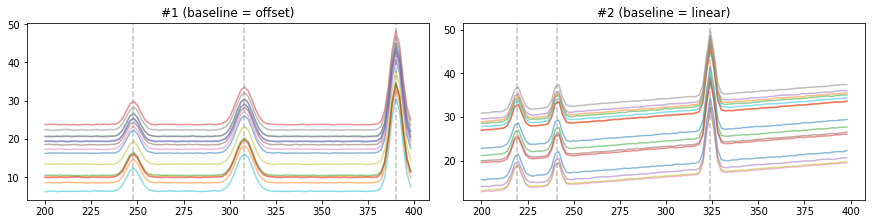

In [19]:
# plot datasets
fig.plot_datasets(ldata, lpeaks, dims=(int(tsets/2),2), figure_size=(12,int(tsets*(1.8))), 
                            savefig='yes', fname=file_basename, scenario='baseline', labels=lbline)

# Initialize models and run inference

In [20]:
# convert pandas data to numpy arrays
x_val = np.array(xval, dtype='float32')

# store dataset y-values in list
cols = ldata[0].columns
y_val = [ldata[i][cols].values for i in range(len(ldata))]

In [21]:
# initialize models and run inference
models = []
traces = []

# list of tuples with (model baseline, data baseline) combination
lmodbase = []

# actual run number
run = 1

# total number of inference runs
truns = nsets * len(baselines)**2

for bl in baselines:
    if conf['model_mode'] == 'train':
        # for each baseline model run inference on all spectra
        print("running: baseline-{0} model".format(bl))
    
    for i in range(len(ldata)):
        if conf['peak_info'] == 'yes':
            #plist = lpeaks[i].flatten()
            plist = np.array(lpeaks[i], dtype='float32').flatten()
            plist.sort()
            model_g = mdl.model_pvoigt(xvalues=x_val, observations=y_val[i], npeaks=3, 
                                  mu_peaks=plist, pmodel=conf['prior_model'], baseline=bl)
        else:
            model_g = mdl.model_pvoigt(xvalues=x_val, observations=y_val[i], npeaks=3,
                                                  pmodel=conf['prior_model'], baseline=bl)
                
        models.append(model_g)

        with model_g:
            if conf['model_mode'] == 'train':
                print("({2}/{3}) running inference on dataset #{0}/{1} [{4} model: {5} data]"
                      .format(i+1,len(ldata),run,truns,bl,lbline[i]))
                trace_g = pm.sample(conf['nsamples'], init=conf['init_mode'], cores=conf['ncores'])
                lmodbase += [(bl,lbline[i])]
                traces.append(trace_g)
                # save inference results
                pm.backends.text.dump(out_path + '/traces_%02d' % (run), trace_g)
            else:
                # load traces from disk
                print("loading dataset #{0}/{1}".format(run,truns))
                trace_g = pm.backends.text.load(out_path + '/traces_%02d' % (run))
                traces.append(trace_g)
            run += 1

running: baseline-offset model


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(1/4) running inference on dataset #1/2 [offset model: offset data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, a0, sigma, mu, amp]
Sampling 2 chains, 6 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 302.61draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(2/4) running inference on dataset #2/2 [offset model: linear data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, a0, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 387.74draws/s]


running: baseline-linear model


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(3/4) running inference on dataset #1/2 [linear model: offset data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, a1, a0, sigma, mu, amp]
Sampling 2 chains, 228 divergences: 100%|██████████| 5000/5000 [00:37<00:00, 132.71draws/s]
There were 217 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6460615240341172, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.910176919507745, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(4/4) running inference on dataset #2/2 [linear model: linear data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, a1, a0, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:57<00:00, 86.49draws/s] 
The acceptance probability does not match the target. It is 0.9491932567018583, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9677948229455946, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


# Model visualization

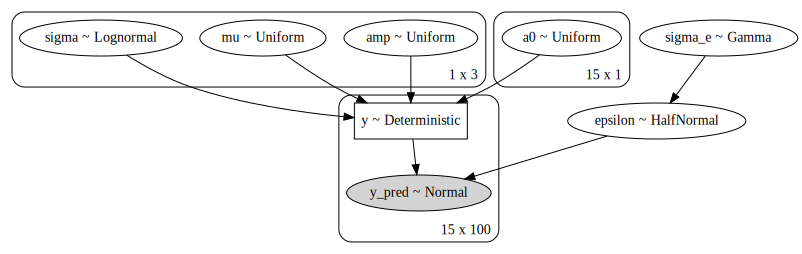

In [22]:
# display first model
pm.model_to_graphviz(models[0])

In [23]:
# save model figure as image, for each model
z = 0
for i in range(len(models)):
    if i % len(lbline) == 0:
        img = pm.model_to_graphviz(models[i])
        img.render(filename=file_basename + '_model_{0}'.format(baselines[z]), format='png');
        z += 1

# Collect results and save

In [24]:
# posterior predictive traces
ppc = [pm.sample_posterior_predictive(traces[i], samples=500, model=models[i]) for i in range(len(traces))]

/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:01<00:00, 367.72it/s]
/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:01<00:00, 357.70it/s]


In [25]:
# various plots to inspect the inference results
varnames = mdl.get_varnames(traces[0])

#az.plot_trace(traces[2], varnames, compact=True);
#az.plot_trace(traces[2], varnames, divergences='top');
#az.plot_autocorr(traces[0], varnames);
#az.plot_posterior(traces[20], varnames);

#for idx, trace in enumerate(traces):
#    az.plot_forest(trace, var_names = varnames, r_hat=True, ess=True);

#az.summary(traces[20], varnames)

In [26]:
if conf['model_mode'] == 'train':
    # collect the results and display
    df = res.get_results_summary(traces, ppc, y_val, epsilon_real=0.05, sets=tsets, 
                                 labels=lmodbase, multimodels='yes')
else:
    # load results from disk
    df = pd.read_csv(file_basename + '.csv')
    df.index += 1
    
    # create list of tuples with model/data combinations
    lm = df['model'].to_list()
    ld = df['data'].to_list()
    lmodbase = list(zip(lm,ld))
df

/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,r_hat,mcse,ess,bfmi,r2,waic,epsilon,epsilon_real,model,data
1,1.000000,0.000000,5273.080000,1.017344,0.999942,-4592.962544,0.051917,0.05,offset,offset
2,1.000000,0.002880,6308.840000,1.037199,0.931270,5994.857940,1.775553,0.05,offset,linear
3,1.025000,0.000615,470.153846,1.057429,0.999942,-4593.053718,0.051927,0.05,linear,offset
4,1.006154,0.000000,1427.769231,1.019689,0.999944,-4670.243610,0.050567,0.05,linear,linear


In [27]:
if conf['model_mode'] == 'train':
    # save results to .csv
    df.to_csv(file_basename + '.csv', index=False)

# Plot posterior

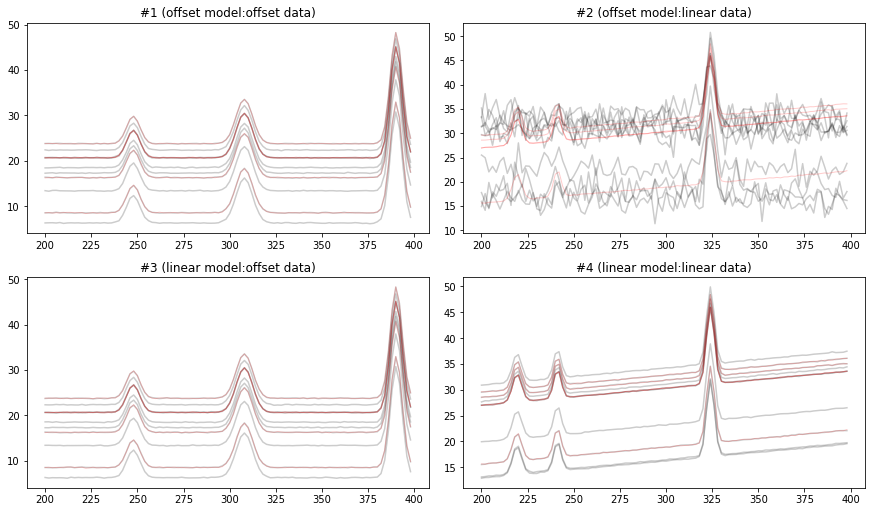

In [28]:
import importlib
importlib.reload(fig)

fig.plot_posterior(x_val, ldata, traces, ppc, dims=(int(truns/2),2), figure_size=(12,int(truns*(1.8))),
            savefig='yes', fname=file_basename, showpeaks='no', sets=tsets, labels=lmodbase, scenario='baseline')

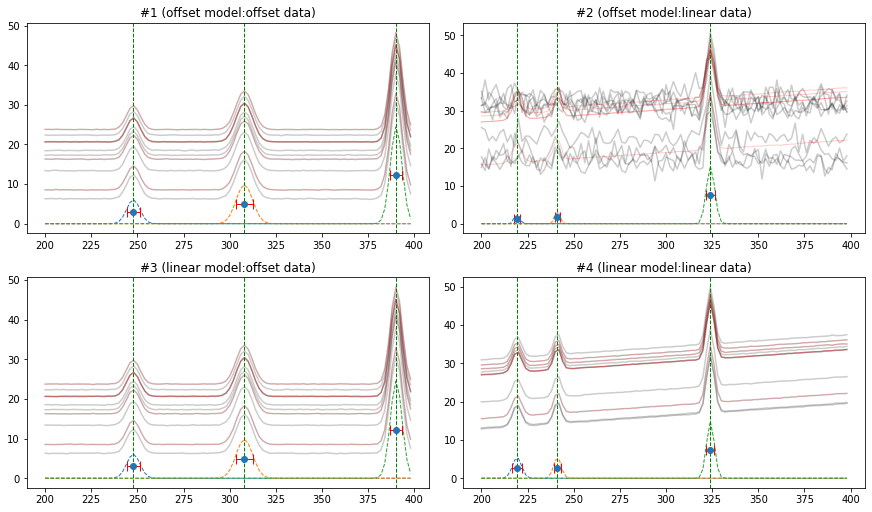

In [29]:
fig.plot_posterior(x_val, ldata, traces, ppc, dims=(int(truns/2),2), figure_size=(12,int(truns*(1.8))),
            savefig='yes', fname=file_basename, showpeaks='yes', sets=tsets, labels=lmodbase, scenario='baseline')

In [30]:
cnf.close(out_path)

# Plot posterior (single dataset)

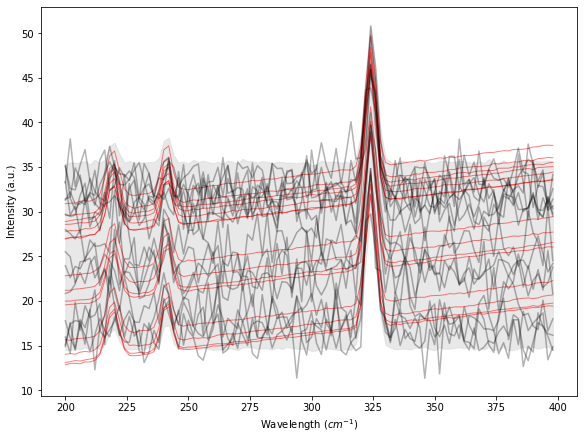

In [44]:
# dataset to plot
n_dataset = 1

# trace number in matrix
n_trace = 1

fig.plot_posterior_single(x_val, ldata[n_dataset], ppc[n_trace], 15, file_basename, hpd_color='lightgray')

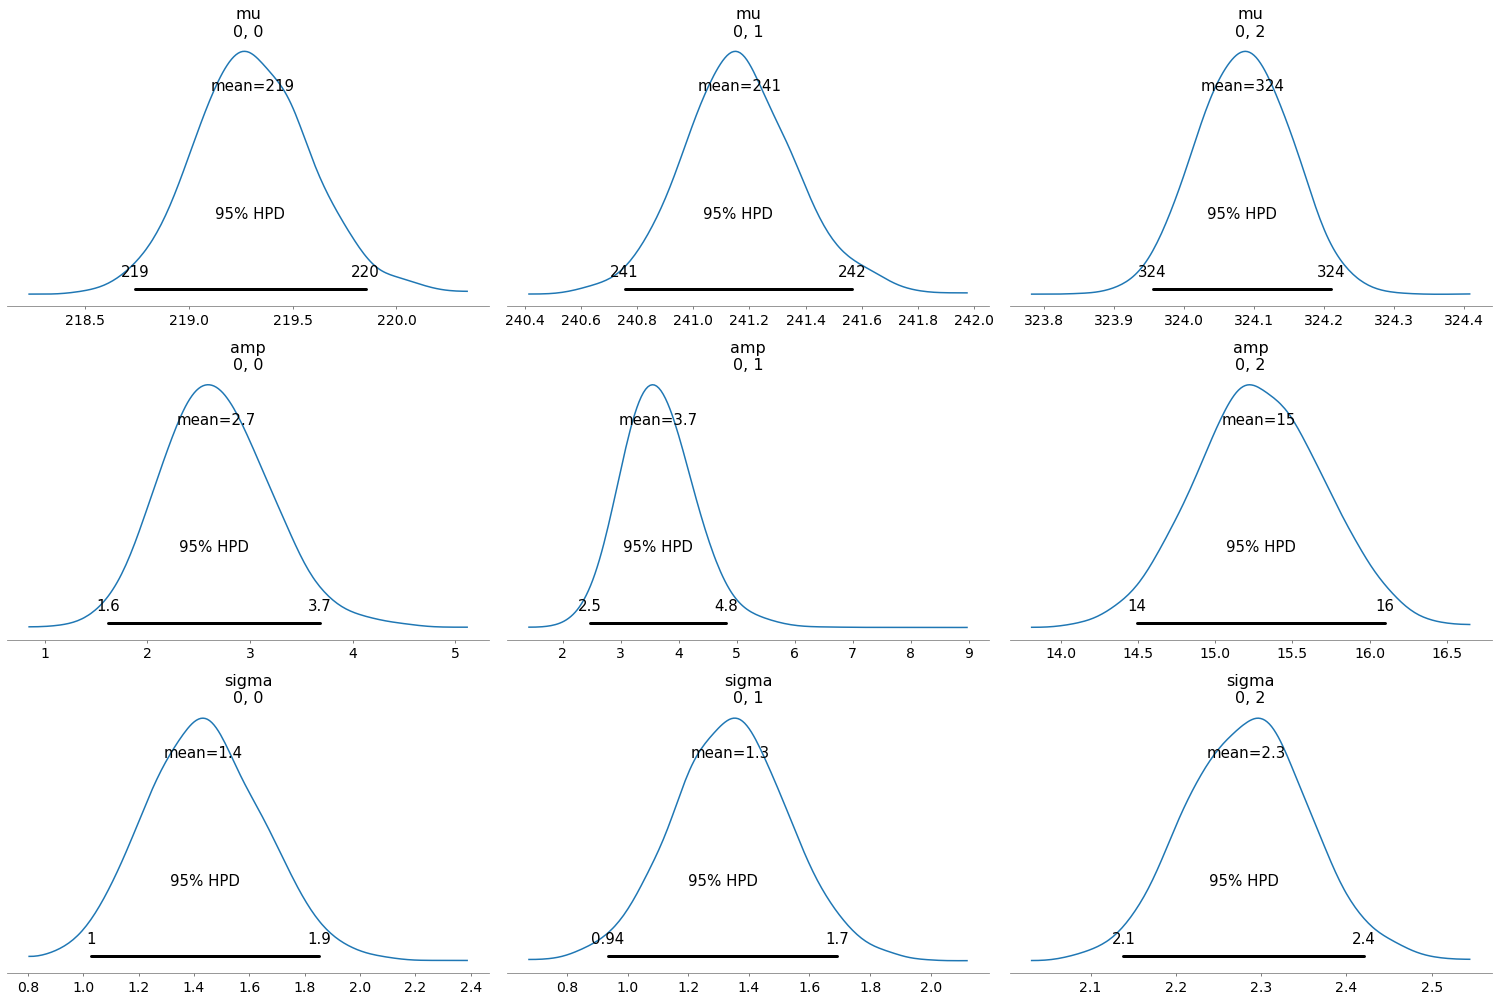

In [37]:
az.plot_posterior(traces[n_trace], ['mu', 'amp', 'sigma'], credible_interval=0.95);

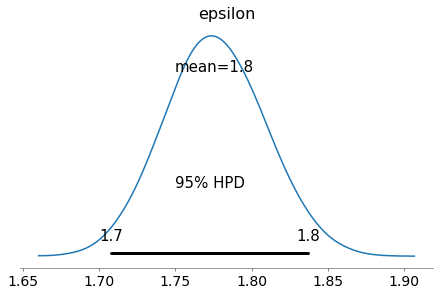

In [38]:
az.plot_posterior(traces[n_trace], ['epsilon'], credible_interval=0.95);

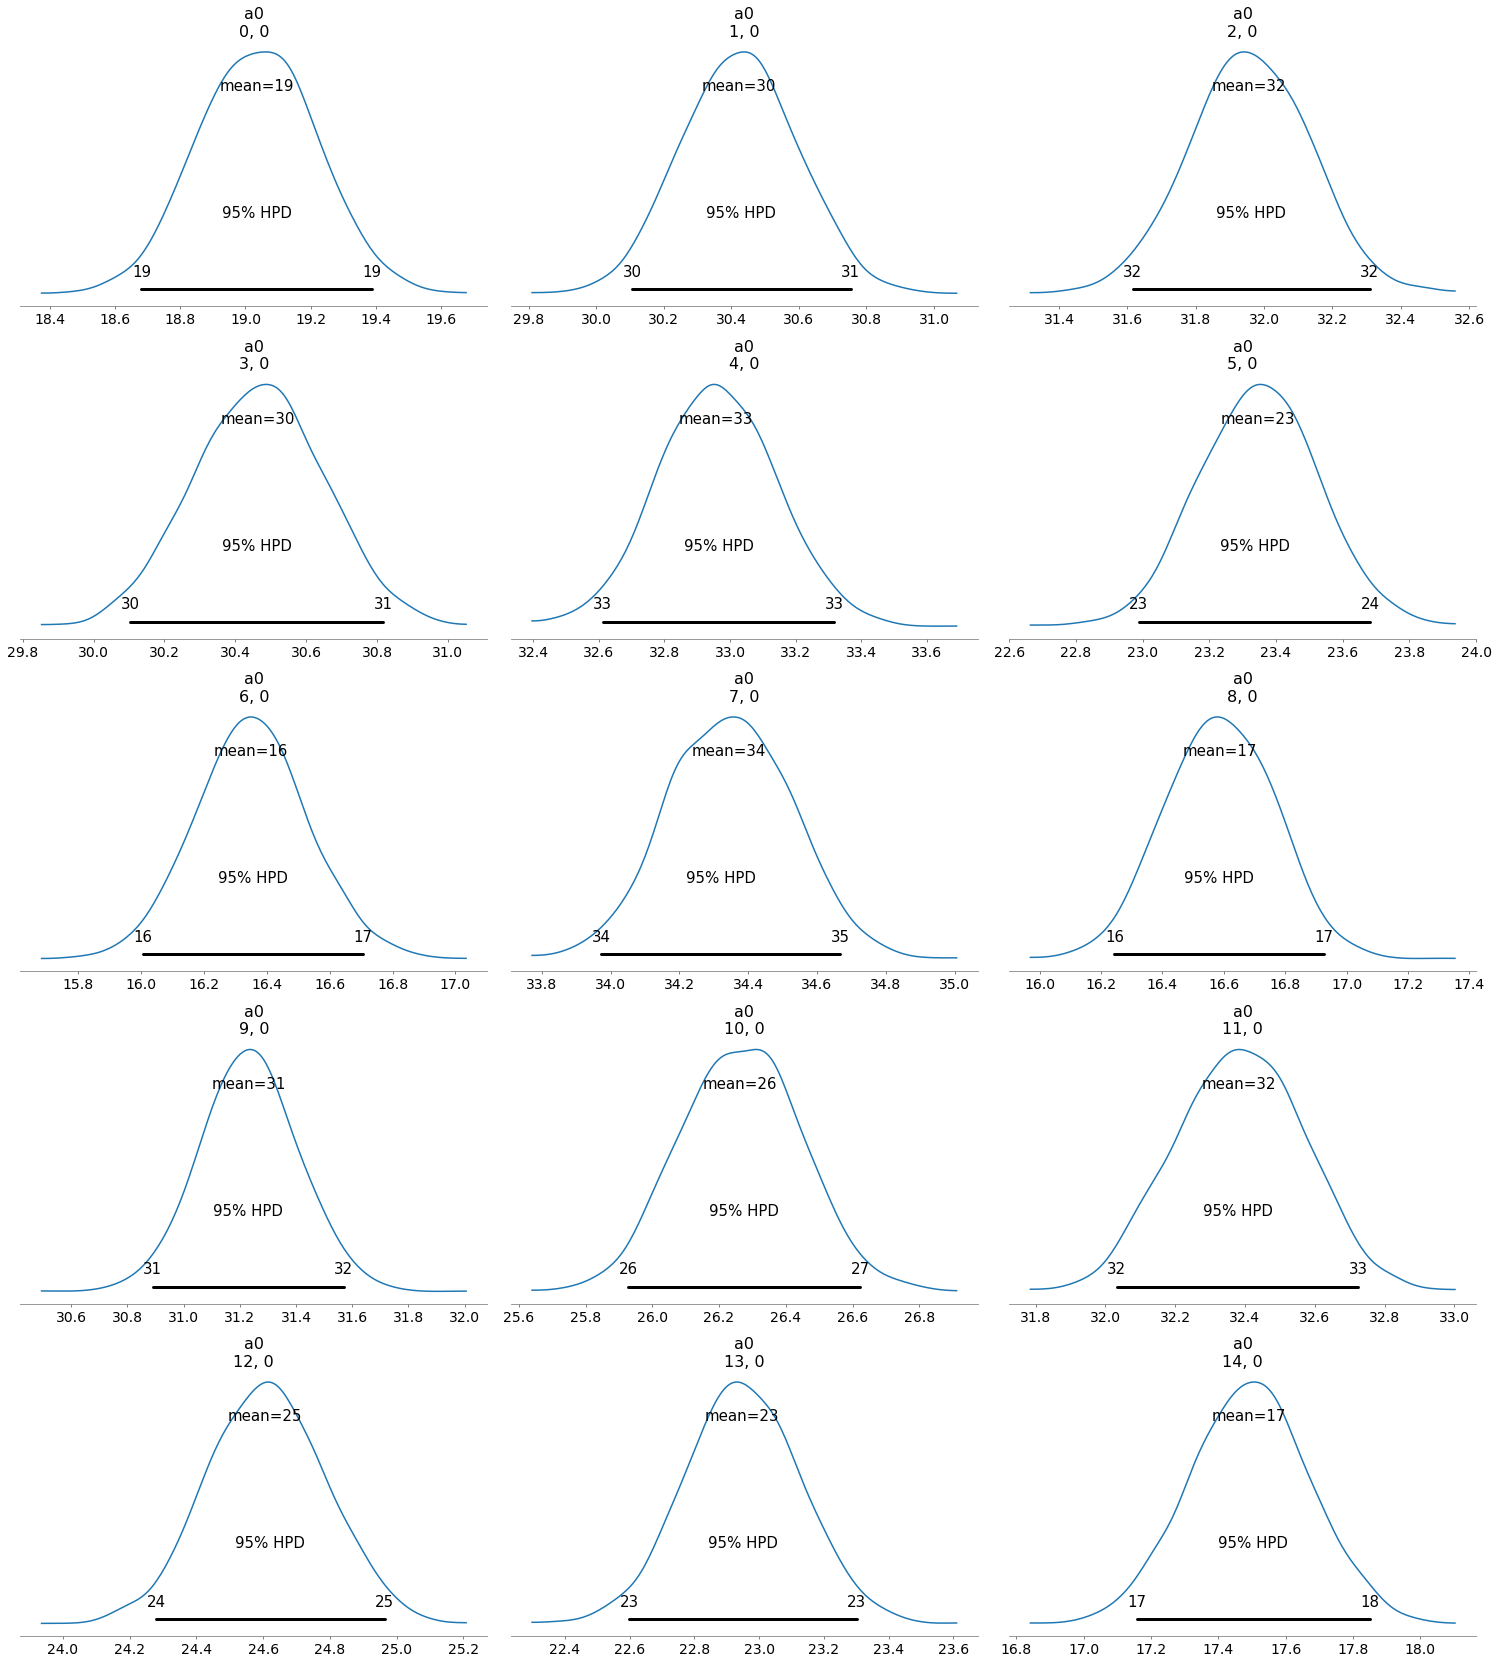

In [39]:
az.plot_posterior(traces[n_trace], ['a0'], credible_interval=0.95);

In [42]:
#az.plot_posterior(traces[n_trace], ['a1'], credible_interval=0.95);